In [1]:
import numpy as np
import pandas as pd

In [82]:
df = pd.read_csv("C:/Users/Hangyu/Desktop/loan.csv")     #change to your own path

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [49]:
df.shape   #dimension of our dataset

(887379, 74)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 74 columns):
id                             887379 non-null int64
member_id                      887379 non-null int64
loan_amnt                      887379 non-null float64
funded_amnt                    887379 non-null float64
funded_amnt_inv                887379 non-null float64
term                           887379 non-null object
int_rate                       887379 non-null float64
installment                    887379 non-null float64
grade                          887379 non-null object
sub_grade                      887379 non-null object
emp_title                      835917 non-null object
emp_length                     842554 non-null object
home_ownership                 887379 non-null object
annual_inc                     887375 non-null float64
verification_status            887379 non-null object
issue_d                        887379 non-null object
loan_status          

In [5]:
df.loan_status.value_counts()   #what we want to predict

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [ ]:
#Part 1, pre-processing

In [23]:
#1-1, 
#Since the data can be devided into 2 groups, with co-borrowers or without co-borrowers
#application_type， Indicates whether the loan is an individual application or a joint application with two co-borrowers
df.application_type.value_counts()   
#only 511 has co-borrowers, so we drop all co-borrowers' information, and keep application_type(which can be a indicator for loan status)

In [83]:
new_df = df.drop(['annual_inc_joint','dti_joint','verification_status_joint','acc_now_delinq','tot_coll_amt','tot_cur_bal','open_acc_6m','open_il_6m','open_il_12m',
                  'open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util',
                  'total_rev_hi_lim','inq_fi','total_cu_tl','inq_last_12m'], axis=1)
new_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,0.00,0.00,Jan-2015,357.48,NaN,Jan-2015,0.0,NaN,1.0,INDIVIDUAL
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,0.00,0.00,Jan-2016,67.79,Feb-2016,Jan-2016,0.0,NaN,1.0,INDIVIDUAL


In [85]:
#1-2. Check Missing Value
missing_portion = new_df.isnull().sum()/len(new_df)    #calculate the portion of missing value
print(missing_portion.sort_values(ascending=False))
#Here,pick a value and drop the factors base on the missing portion
#My initial thought was drop everything above the "emp_title" , but when I looked into the columns' description
#Factors like mths_since_last_record is definitely related to loan status, so I have to look into these factors 1 by 1

desc                           0.857977
mths_since_last_record         0.845553
mths_since_last_major_derog    0.750160
mths_since_last_delinq         0.511971
next_pymnt_d                   0.285077
emp_title                      0.057993
emp_length                     0.050514
last_pymnt_d                   0.019900
revol_util                     0.000566
title                          0.000171
collections_12_mths_ex_med     0.000163
last_credit_pull_d             0.000060
total_acc                      0.000033
delinq_2yrs                    0.000033
inq_last_6mths                 0.000033
open_acc                       0.000033
pub_rec                        0.000033
earliest_cr_line               0.000033
annual_inc                     0.000005
url                            0.000000
member_id                      0.000000
loan_amnt                      0.000000
sub_grade                      0.000000
grade                          0.000000
installment                    0.000000


In [92]:
#a. desc: Loan description provided by the borrower
#can be dropped, texture data, and lots of missing value
new_df_2 = new_df.drop(['desc'], axis=1)

In [93]:
#b. mths_since_last_record: The number of months since the last public record.
#c. mths_since_last_major_derog: Months since most recent 90-day or worse rating
#d. mths_since_last_delinq: The number of months since the borrower's last delinquency.    
#can not be dropped, I guess the missing values should be replaced with "0" ***need further verification***
values = {'mths_since_last_record': 0, 'mths_since_last_major_derog': 0, 'mths_since_last_delinq': 0}

In [94]:
new_df_3 = new_df_2.fillna(value=values)

In [100]:
#e. next_pymnt_d: Next scheduled payment date
new_df_4 = new_df_3.drop(['next_pymnt_d'], axis=1)

In [101]:
new_df_4.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,0.00,0.00,0.00,Jan-2015,171.62,Jan-2016,0.0,0.0,1.0,INDIVIDUAL
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,0.0,1.0,INDIVIDUAL
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,0.00,0.00,0.00,Jun-2014,649.91,Jan-2016,0.0,0.0,1.0,INDIVIDUAL
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,16.97,0.00,0.00,Jan-2015,357.48,Jan-2015,0.0,0.0,1.0,INDIVIDUAL
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,0.00,0.00,0.00,Jan-2016,67.79,Jan-2016,0.0,0.0,1.0,INDIVIDUAL


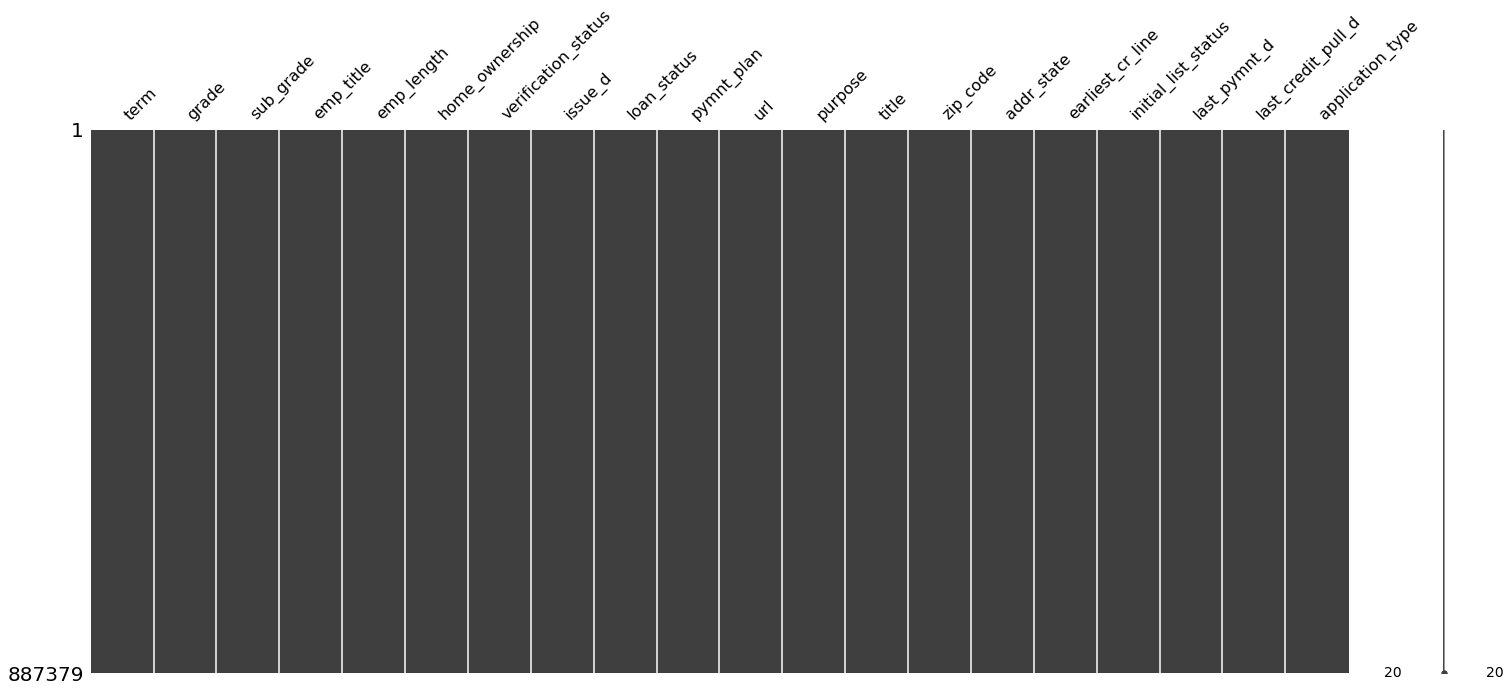

In [114]:
#1-3. Missing Value Continued.(replacing missing value)
import missingno as msno
%matplotlib inline
objectColumns = new_df_4.select_dtypes(include=["object"]).columns 
new_df_4[objectColumns] = new_df_4[objectColumns].fillna("Unknown") 
msno.matrix(new_df_4[objectColumns])  

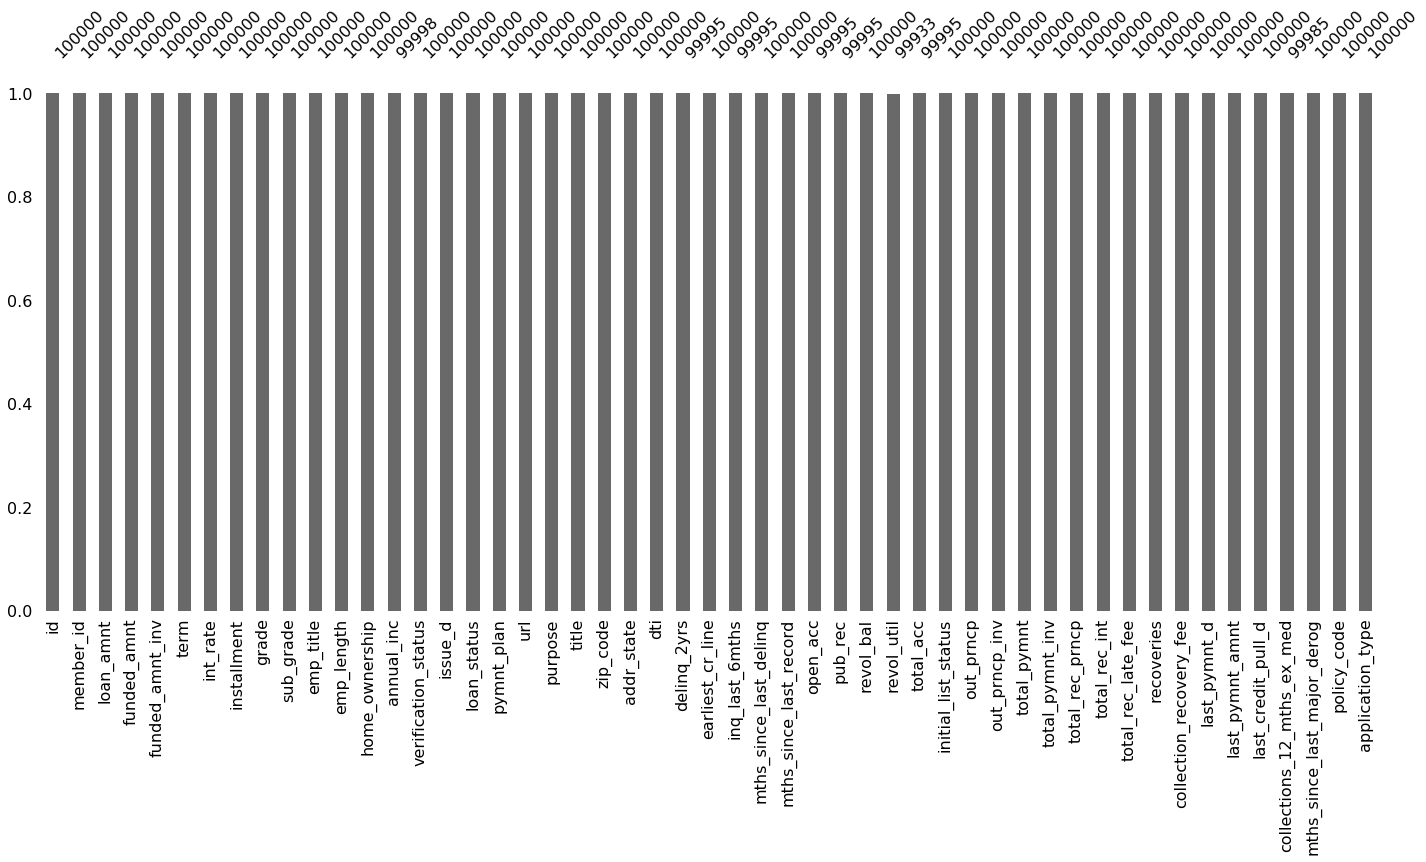

In [118]:
msno.bar(new_df_4.sample(100000))